In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
from functools import reduce
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()


from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (8, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("theta-rhythmicity")
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [6]:
theta_action = actions['theta-rhythmicity']
theta_results = pd.read_csv(theta_action.data_path('results'))

In [7]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [8]:
data = data.drop(columns='theta_score').merge(theta_results, how='left')

In [9]:
data = data.merge(stim_results, how='left')

In [10]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

In [11]:
keys = [
    'theta_score',
    'theta_bandpower',
    'theta_relpower',
    'theta_relpeak',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'stim_bandpower',
    'stim_relpower',
    'stim_relpeak',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
]

In [12]:
results, labels = make_paired_tables(data, keys)

In [13]:
results['gridcell']['theta_relpeak']

,entity,unit_idnum,channel_group,date,Baseline I,11 Hz,Baseline II,30 Hz
51,1833,8,0,20719,1.248894,NaN,NaN,NaN
85,1833,13,0,20719,NaN,0.037071,1.287301,0.176807
86,1833,14,0,20719,NaN,0.107253,1.573884,NaN
58,1833,23,0,200619,1.032539,NaN,NaN,NaN
127,1833,26,0,200619,NaN,NaN,0.851083,0.265955
...,...,...,...,...,...,...,...,...
139,1849,835,4,150319,NaN,NaN,NaN,2.182959
43,1849,851,5,60319,2.999367,NaN,NaN,NaN
65,1849,932,7,280219,1.869360,NaN,NaN,NaN
74,1849,937,7,280219,NaN,0.264037,NaN,NaN


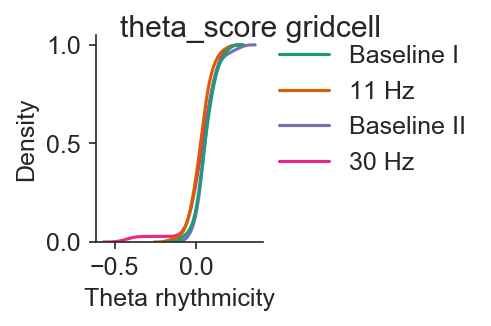

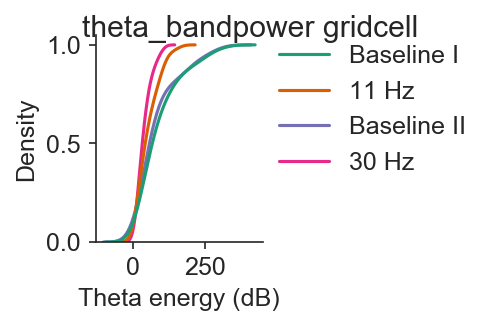

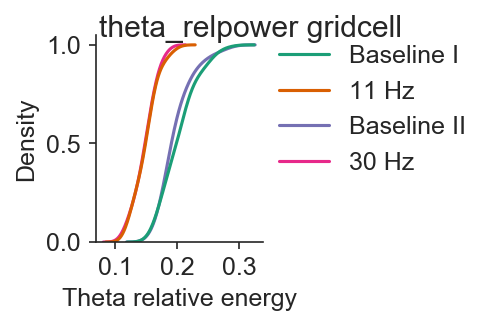

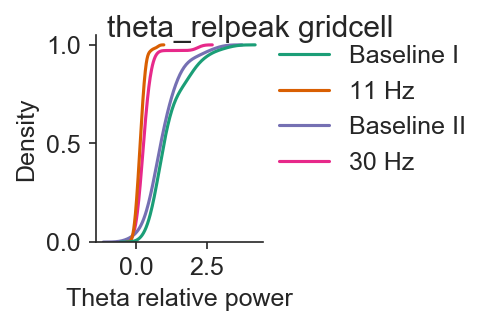

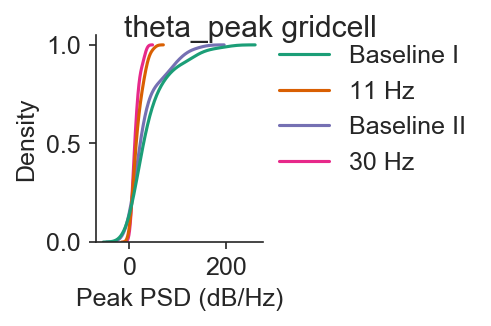

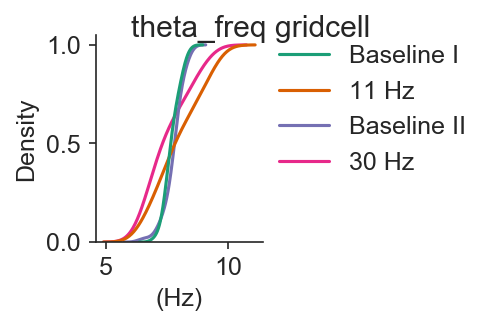

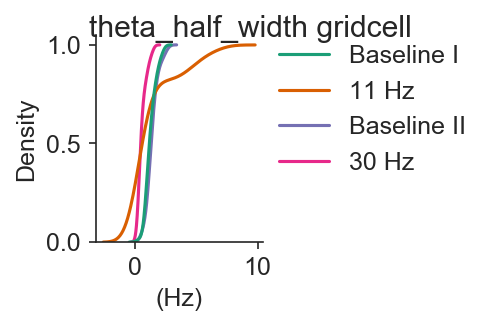

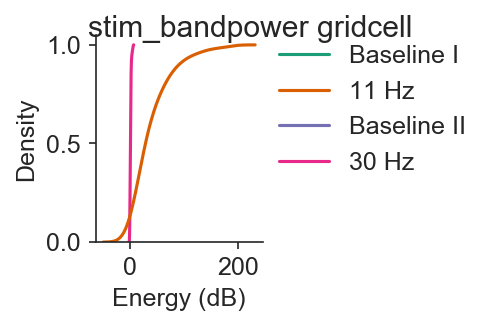

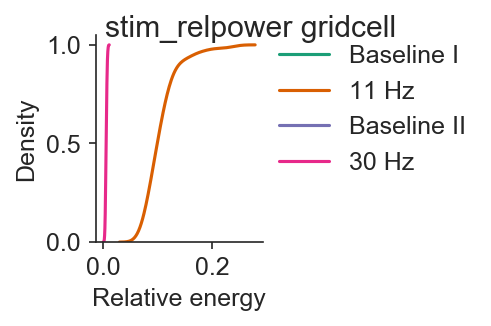

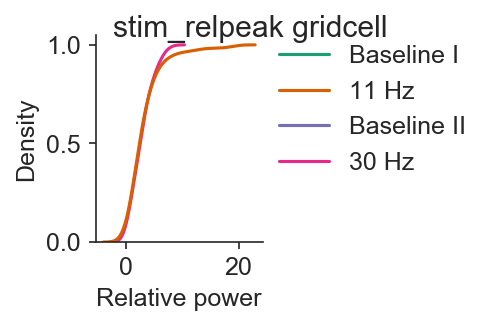

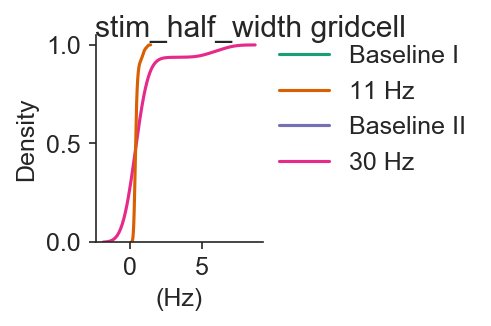

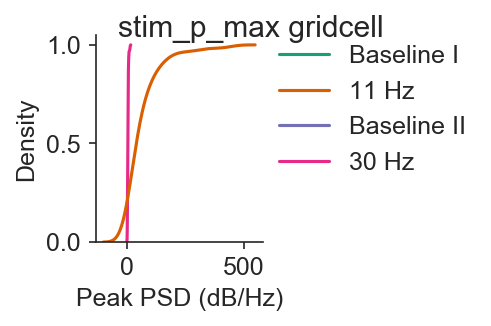

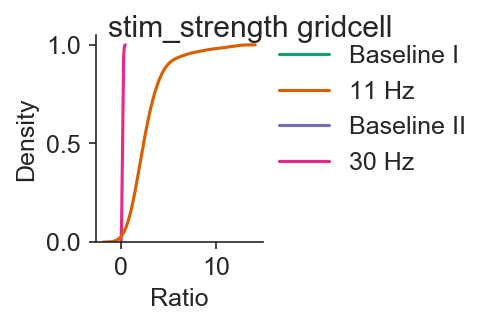

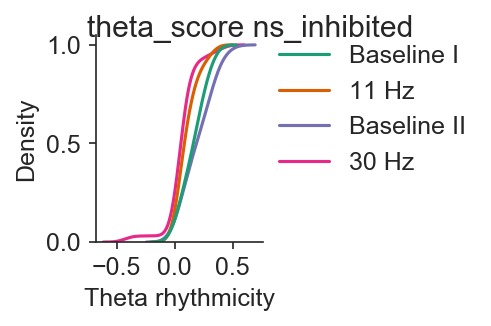

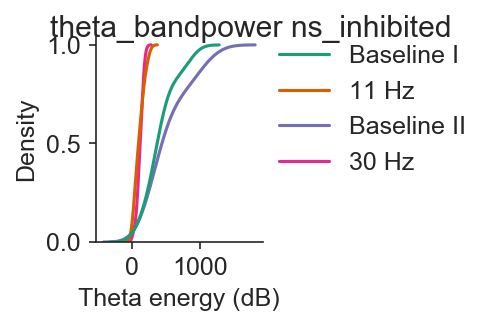

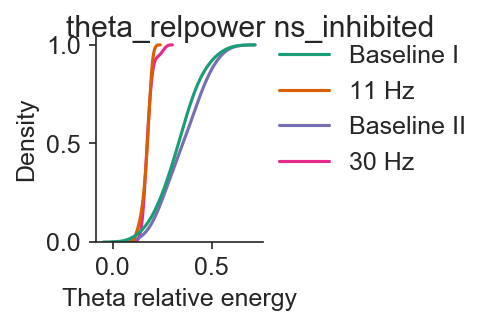

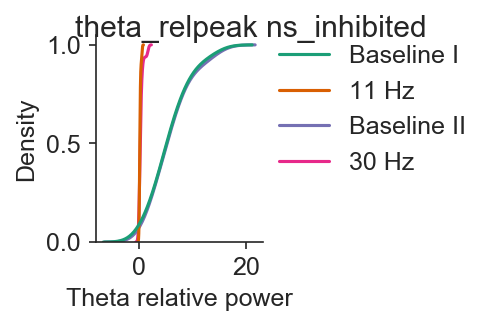

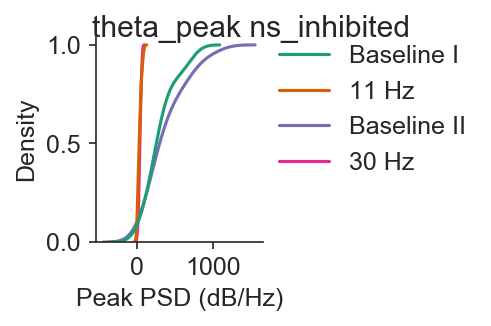

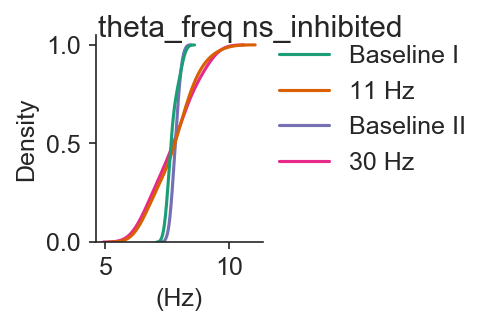

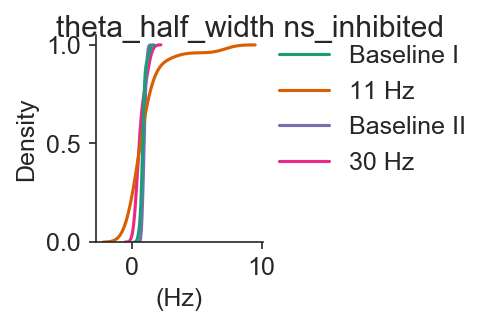

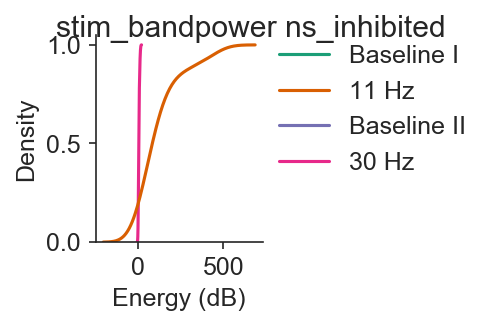

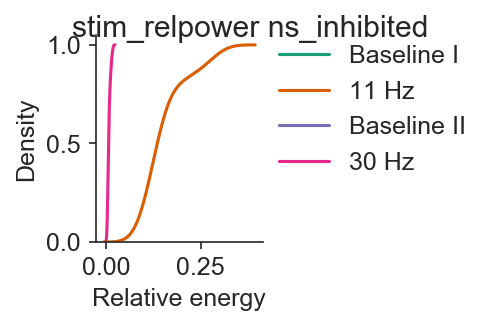

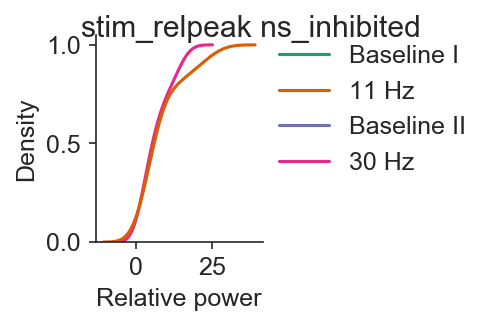

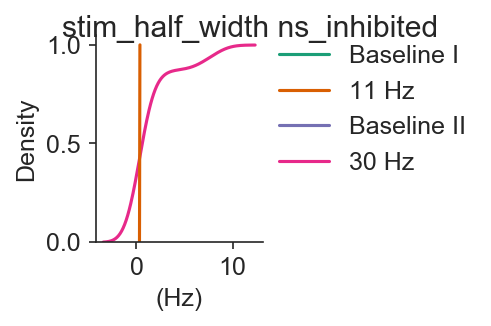

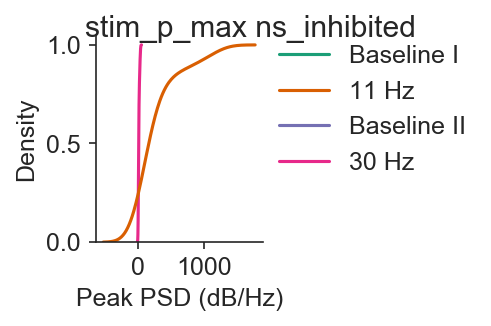

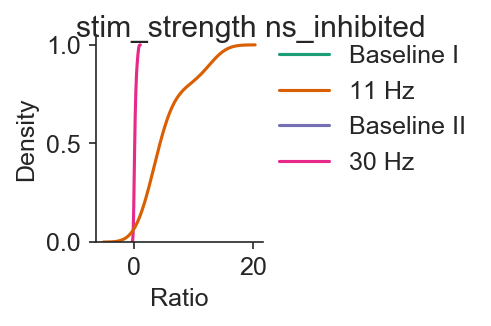

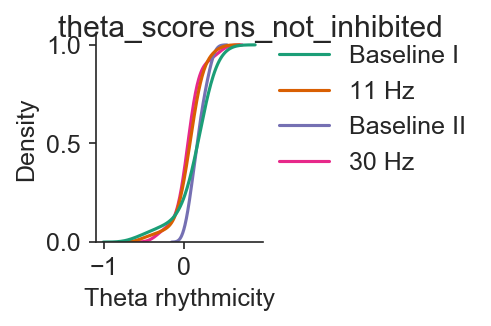

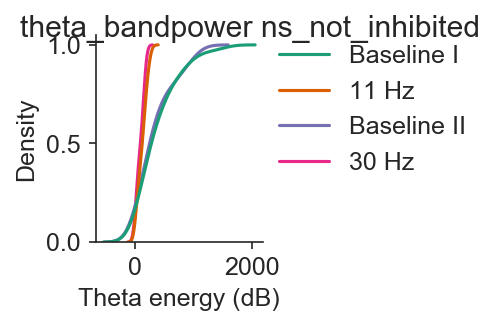

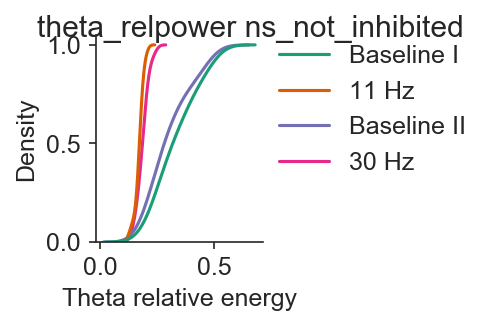

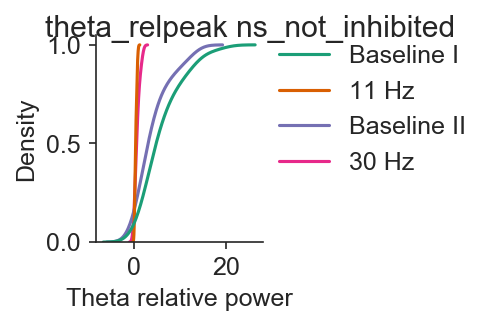

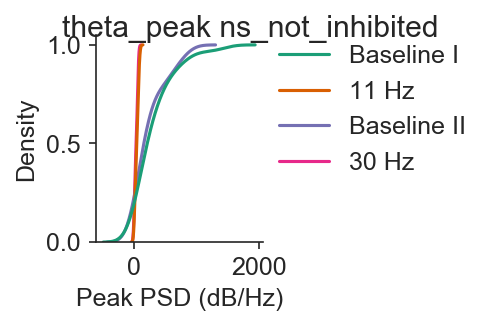

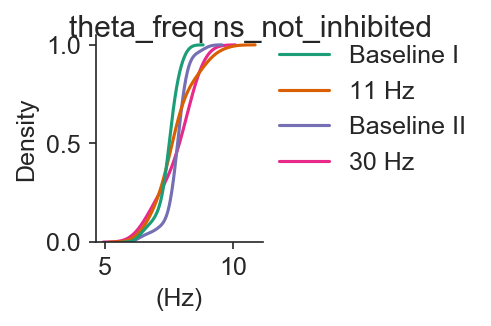

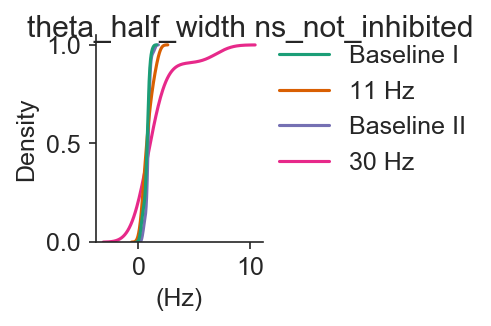

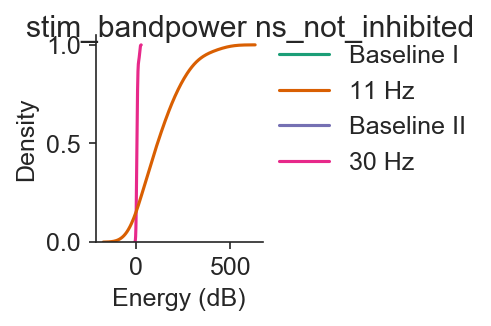

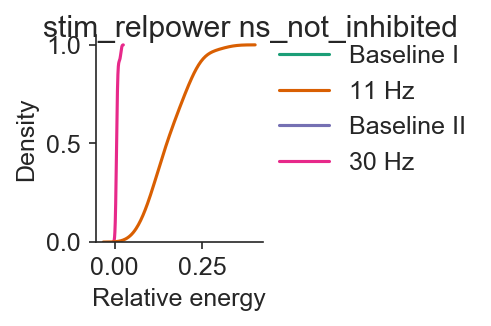

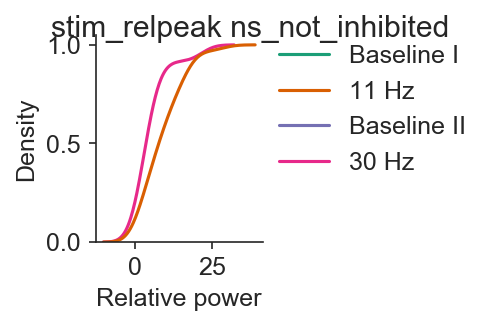

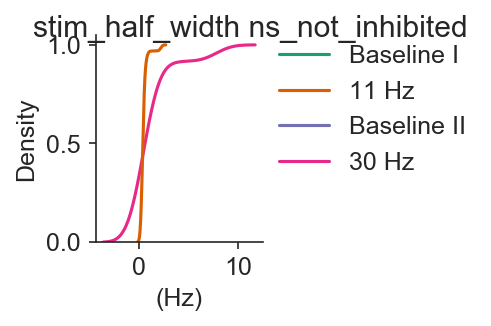

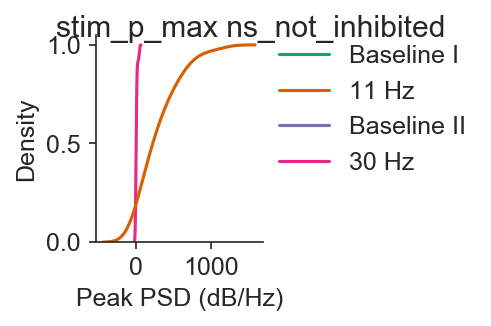

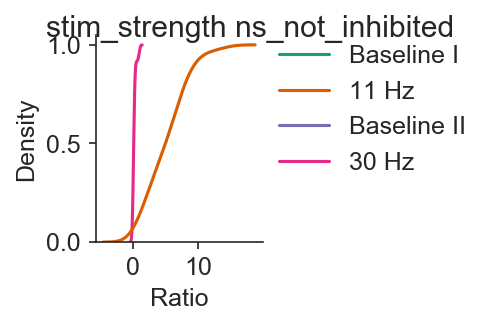

In [14]:
xlabel = {
    'theta_score': 'Theta rhythmicity',
    'theta_bandpower': 'Theta energy (dB)',
    'theta_relpower': 'Theta relative energy',
    'theta_relpeak': 'Theta relative power',
    'theta_peak': 'Peak PSD (dB/Hz)',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
    'stim_bandpower': 'Energy (dB)',
    'stim_relpower': 'Relative energy',
    'stim_relpeak': 'Relative power',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak PSD (dB/Hz)',
    'stim_strength': 'Ratio',
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in keys:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
#         plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'theta-rhythmicity-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

# stats

In [28]:
stats = {}
for cell_type, result in results.items():
    stats[cell_type], _ = make_statistics_table(result, labels)

In [29]:
stats['gridcell']

,Theta score,Theta bandpower,Theta relpower,Theta relpeak,Theta peak,Theta freq,Theta half width,Stim bandpower,Stim relpower,Stim relpeak,Stim half width,Stim p max,Stim strength
Baseline I,6.5e-02 ± 9.0e-03 (63),1.1e+02 ± 1.3e+01 (63),2.1e-01 ± 4.2e-03 (63),1.3e+00 ± 9.8e-02 (63),5.5e+01 ± 7.7e+00 (63),7.8e+00 ± 5.5e-02 (63),1.1e+00 ± 5.9e-02 (63),NaN,NaN,NaN,NaN,NaN,NaN
11 Hz,2.0e-02 ± 8.5e-03 (56),6.2e+01 ± 5.9e+00 (56),1.6e-01 ± 2.3e-03 (56),1.9e-01 ± 2.3e-02 (56),2.0e+01 ± 2.0e+00 (56),7.6e+00 ± 1.3e-01 (56),8.9e-01 ± 1.8e-01 (56),4.8e+01 ± 5.9e+00 (58),1.1e-01 ± 4.7e-03 (58),3.8e+00 ± 5.0e-01 (58),4.3e-01 ± 2.7e-02 (58),7.8e+01 ± 1.3e+01 (58),3.1e+00 ± 3.1e-01 (58)
Baseline II,9.9e-02 ± 1.3e-02 (46),1.2e+02 ± 1.3e+01 (46),2.2e-01 ± 6.4e-03 (46),1.3e+00 ± 1.3e-01 (46),5.4e+01 ± 6.2e+00 (46),8.0e+00 ± 5.0e-02 (46),1.2e+00 ± 5.4e-02 (44),NaN,NaN,NaN,NaN,NaN,NaN
30 Hz,3.6e-02 ± 1.9e-02 (35),4.5e+01 ± 5.1e+00 (35),1.5e-01 ± 3.4e-03 (35),5.0e-01 ± 1.1e-01 (35),1.5e+01 ± 1.7e+00 (35),7.4e+00 ± 1.6e-01 (35),6.0e-01 ± 7.0e-02 (33),1.7e+00 ± 2.8e-01 (33),4.9e-03 ± 3.1e-04 (33),2.9e+00 ± 3.6e-01 (33),4.9e-01 ± 1.5e-01 (32),2.5e+00 ± 5.3e-01 (33),1.3e-01 ± 1.4e-02 (33)
LMM Baseline I - 11 Hz,"$\rho$=-4.2e-02, p=4.8e-02","$\rho$=-3.7e+01, p=2.3e-02","$\rho$=-5.8e-02, p=1.7e-12","$\rho$=-1.0e+00, p=2.4e-02*","$\rho$=-2.9e+01, p=9.6e-02","$\rho$=-1.1e-01, p=7.4e-01","$\rho$=-2.1e-01, p=6.3e-01",NaN,NaN,NaN,NaN,NaN,NaN
LMM Baseline I - Baseline II,"$\rho$=1.7e-02, p=4.6e-01","$\rho$=8.1e-01, p=9.6e-01","$\rho$=-2.2e-03, p=6.9e-01","$\rho$=-9.4e-02, p=5.3e-01*","$\rho$=-8.9e+00, p=3.4e-01","$\rho$=1.2e-01, p=1.3e-01","$\rho$=7.0e-02, p=6.8e-01",empty,empty,empty,empty,empty,empty
LMM Baseline I - 30 Hz,"$\rho$=-2.2e-02, p=1.7e-01","$\rho$=-6.0e+01, p=9.7e-02","$\rho$=-6.3e-02, p=2.7e-06","$\rho$=-8.5e-01, p=6.0e-13**","$\rho$=-3.7e+01, p=4.0e-09","$\rho$=-3.8e-01, p=2.1e-01","$\rho$=-5.1e-01, p=2.2e-07",empty,empty,empty,empty,empty,empty
LMM 11 Hz - Baseline II,"$\rho$=8.3e-02, p=9.7e-03","$\rho$=5.7e+01, p=3.0e-02","$\rho$=6.6e-02, p=8.4e-05","$\rho$=1.1e+00, p=5.0e-03*","$\rho$=3.3e+01, p=2.0e-02","$\rho$=3.2e-01, p=4.6e-01","$\rho$=2.4e-01, p=7.0e-01",empty,empty,empty,empty,empty,empty
LMM 11 Hz - 30 Hz,"$\rho$=1.7e-02, p=7.8e-01","$\rho$=-1.3e+01, p=2.8e-01","$\rho$=-5.4e-03, p=4.8e-01","$\rho$=3.2e-01, p=7.8e-02","$\rho$=-4.1e+00, p=2.9e-01","$\rho$=-4.5e-01, p=3.0e-01","$\rho$=-4.9e-01, p=4.2e-01","$\rho$=-4.3e+01, p=2.3e-04","$\rho$=-1.0e-01, p=1.7e-161*","$\rho$=-1.7e-01, p=7.7e-01**","$\rho$=2.3e-01, p=4.6e-01","$\rho$=-6.5e+01, p=3.3e-03","$\rho$=-2.9e+00, p=8.9e-19*"
LMM Baseline II - 30 Hz,"$\rho$=-3.2e-02, p=1.3e-03","$\rho$=-5.9e+01, p=5.8e-02","$\rho$=-7.0e-02, p=1.5e-01","$\rho$=-6.7e-01, p=5.6e-10**","$\rho$=-3.9e+01, p=7.0e-02","$\rho$=-5.1e-01, p=8.3e-02","$\rho$=-7.1e-01, p=7.9e-04",NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [18]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

## psd

In [19]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [20]:
coher = pd.read_feather(output_path / 'data' / 'spike_psd.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [21]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

In [22]:
results['gridcell']['theta_relpeak']

,entity,unit_idnum,channel_group,date,Baseline I,11 Hz,Baseline II,30 Hz
51,1833,8,0,20719,1.248894,NaN,NaN,NaN
85,1833,13,0,20719,NaN,0.037071,1.287301,0.176807
86,1833,14,0,20719,NaN,0.107253,1.573884,NaN
58,1833,23,0,200619,1.032539,NaN,NaN,NaN
127,1833,26,0,200619,NaN,NaN,0.851083,0.265955
...,...,...,...,...,...,...,...,...
139,1849,835,4,150319,NaN,NaN,NaN,2.182959
43,1849,851,5,60319,2.999367,NaN,NaN,NaN
65,1849,932,7,280219,1.869360,NaN,NaN,NaN
74,1849,937,7,280219,NaN,0.264037,NaN,NaN


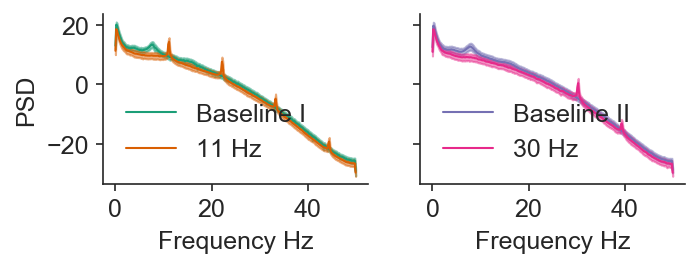

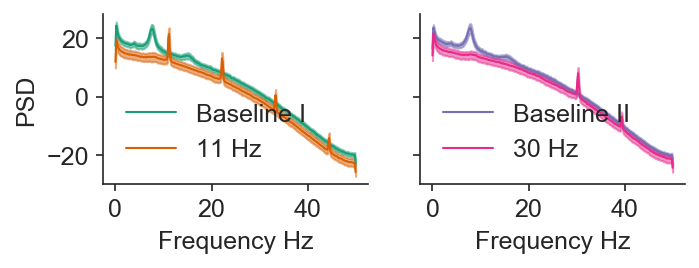

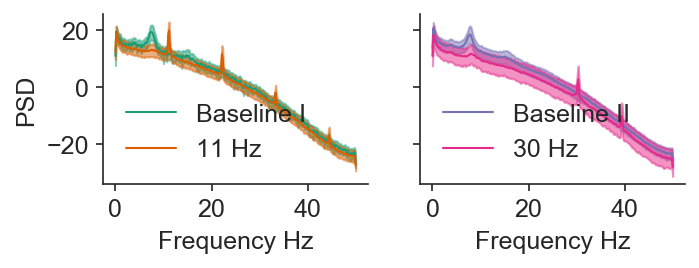

In [23]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,1.5))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
#         ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
#         ax.set_ylim(-30, 0)
    axs[0].set_ylabel('PSD')
    despine()
    figname = f'spike-psd-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [24]:
action = project.require_action("theta-rhythmicity")

In [25]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_theta_relpeak.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_ns_inhibited_theta_bandpower.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_ns_inhibited_stim_bandpower.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_not_gridcell_theta_peak.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_not_gridcell_stim_strength.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_theta_freq.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_st

In [26]:
septum_mec.analysis.registration.store_notebook(action, "20-theta-rhythmicity.ipynb")